# Figure of Stan fits to CD4 data

Results of Stan fits to Leiden-clustered data **for the CD4 data**.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle
import json
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib
import cmdstanpy

import scdynsys.plots as plots
import scdynsys.utilities as utils

tabcolors = [matplotlib.colors.to_hex(plt.cm.tab20(i/20)) for i in range(20)]
tabcolors = [tabcolors[2*i] for i in range(10)] + [tabcolors[2*i+1] for i in range(10)]

tex_fonts = {
    "font.family" : "Helvetica",
    'pdf.fonttype' : 42,
}

plt.rcParams.update(tex_fonts)

## Import data

This notebook uses data generated in the notebook `SequentialApproachFitCD4.ipynb`

In [2]:
## Import data and stan fits

data_file = "../results/data_SA_fitting_CD4.pkl"
lineage = "CD4"

with open(data_file, 'rb') as f:
    data_dict = pickle.load(f)
    
fit_results = data_dict["fit_results"]
celltype_names = data_dict["celltype_names"]
count_scaling = data_dict["count_scaling"]

plotted_models = ["M1", "M2", "M3", "M4"]
model_names = ["Model I", "II", "III", "IV"]
celltype_colors = tabcolors

num_models = len(plotted_models)
num_clusters = len(celltype_names)

# import fancy names used in the SA preprocessing figure

fancy_names_file = f"../results/fancy_names_SA_{lineage}.pkl"
with open(fancy_names_file, 'rb') as f:
    fancy_names = pickle.load(f)

fancy_celltype_names = [fancy_names[name] for name in celltype_names]

## Create the figure

Panels will be added below. We use `wax` rows per model.

In [3]:
wax = 3
gs = GridSpec(num_clusters+1, wax*(num_models+2))

fig = plt.figure(figsize=(14, 1.65*num_clusters))

labx, laby = -0.05, 1.05

fig.subplots_adjust(wspace=0.2, hspace=0.1)

<Figure size 1400x1815 with 0 Axes>

## Plot cell counts and subset frequencies

The top panels show the cell counts, the bottom panels the frequencies.

In [4]:
# get count axes

count_axs = []

ax = None
for i in range(num_models):
    a = wax*i
    ax = fig.add_subplot(gs[0,a:a+wax], sharey=ax)
    count_axs.append(ax)
    
# get freq axes

freq_axss = [[] for _ in range(num_models)]

for j in range(num_clusters):
    ax = None
    for i in range(num_models):
        a = wax*i
        ax = fig.add_subplot(gs[j+1,a:a+wax], sharey=ax)
        freq_axss[i].append(ax)

for i, M in enumerate(plotted_models):
    stan_fit, stan_inits, stan_data, diagnostics = fit_results[M]
    plots.plot_stan_fits_fancy(
        count_axs[i],
        freq_axss[i],
        stan_fit, stan_data,
        count_scaling,
        celltype_colors
    )
    
# add / remove labels
def title_in_graph(ax, title, pos, align):
    ax.text(*pos, title, transform=ax.transAxes, **align)

toppos = (0.95, 0.95)
topaln = dict(va='top', ha='right')

botpos = (0.95, 0.05)
botaln = dict(va='bottom', ha='right')

title_in_graph(count_axs[0], f"{lineage}+ T cell\nnumbers", toppos, topaln) 

# Adjust location of the label for some subsets?
lposses = {}

for j in range(num_models):
    if j > 0:
        plt.setp(count_axs[j].get_yticklabels(), visible=False)
    count_axs[j].xaxis.set_visible(False)
    for i in range(num_clusters):
        name = celltype_names[i]
        fancy_name = fancy_names[name]
        if j == 0:
            lpos, laln = lposses.get(name, (botpos, botaln))
            title_in_graph(freq_axss[0][i], fancy_name, lpos, laln)
        if j > 0:
            plt.setp(freq_axss[j][i].get_yticklabels(which="both"), visible=False)
        if i < num_clusters-1:
            plt.setp(freq_axss[j][i].get_xticklabels(), visible=False)
    freq_axss[j][-1].set_xlabel("DPI")
    count_axs[j].set_title(model_names[j])
    

fig.align_ylabels([count_axs[0]] + [freq_axss[0][i] for i in range(num_clusters)])
    
Ax = fig.add_subplot(gs[0:2,:wax*2])

Ax.axis('off')
Ax.text(labx, laby, "A", fontsize='xx-large', transform=Ax.transAxes)

Text(-0.05, 1.05, 'A')

## Plot parameter estimates (for model II)

Plot $\lambda_E$ and $\lambda_L$ (called $\rho$ and $\eta$ in the Stan model)

In [5]:
pos = [i for i, _ in enumerate(celltype_names)]
xlabs = celltype_names

model_key = "M2"
sam = fit_results[model_key][0]

rho = sam["rho"]
rho_loc = sam["rho_loc"]
eta = sam["eta"]
eta_loc = sam["eta_loc"]
p0 = sam["p0"]

lam_E = -rho
lam_E_loc = -rho_loc
lam_L = -eta
lam_L_loc = -eta_loc

# new parameter naming conventions
ylabs = ["$\\lambda_E$ (per day)", "$\\lambda_L$  (per day)", "$p_0$"]

# convert growth rates to net loss rates lambda

axs = []

n = num_models

ax = fig.add_subplot(gs[0,wax*n+2:wax*(n+2)])
plots.plot_mpd(ax, pos, lam_E)
ax.set_ylabel("early net loss rate\n" + ylabs[0])
axs.append(ax)

ax = fig.add_subplot(gs[1,wax*n+2:wax*(n+2)])
plots.plot_mpd(ax, pos, lam_L)
ax.set_ylabel("late net loss rate\n" + ylabs[1])
axs.append(ax)

ax = fig.add_subplot(gs[2,wax*n+2:wax*(n+2)])
plots.plot_mpd(ax, pos, p0)
ax.set_ylabel("initial frequency\n" + ylabs[2])
axs.append(ax)

for ax in axs:
    ax.set_xticks(pos)
for ax in axs[:-1]:
    ax.axhline(y=0, color='0.7', linestyle='--')
    ax.set_xticklabels([])

axs[-1].set_xticklabels(fancy_celltype_names, rotation=45, ha='right', fontsize='small')

# indicate where the estimates are from
model_name = model_names[plotted_models.index(model_key)].split()[-1]
axs[0].set_title(f"model {model_name}")

fig.align_ylabels(axs)

Ax = fig.add_subplot(gs[0:2,wax*n+2:wax*(n+2)])

Ax.axis('off')
Ax.text(labx, laby, "B", fontsize='xx-large', transform=Ax.transAxes)

Text(-0.05, 1.05, 'B')

## plot parameter estimates (for model III)

Model III only has a single loss rate $\lambda_E$

In [6]:
pos = [i for i, _ in enumerate(celltype_names)]
xlabs = celltype_names

model_key = "M3"
sam = fit_results[model_key][0]

rho = sam["rho"]
rho_loc = sam["rho_loc"]
p0 = sam["p0"]

lam_E = -rho
lam_E_loc = -rho_loc

# new parameter naming conventions
ylabs = ["$\\lambda_E$ (per day)", "$p_0$"]

# convert growth rates to net loss rates lambda

axs = []

vpos = 4

ax = fig.add_subplot(gs[vpos, wax*n+2:wax*(n+2)])
plots.plot_mpd(ax, pos, lam_E)
ax.set_ylabel("net loss rate\n" + ylabs[0])
axs.append(ax)

ax = fig.add_subplot(gs[vpos+1,wax*n+2:wax*(n+2)])
plots.plot_mpd(ax, pos, p0)
ax.set_ylabel("initial frequency\n" + ylabs[1])
axs.append(ax)

for ax in axs:
    ax.set_xticks(pos)
for ax in axs[:-1]:
    ax.axhline(y=0, color='0.7', linestyle='--')
    ax.set_xticklabels([])

axs[-1].set_xticklabels(fancy_celltype_names, rotation=45, ha='right', fontsize='small')

# indicate where the estimates are from
model_name = model_names[plotted_models.index(model_key)].split()[-1]
axs[0].set_title(f"model {model_name}")

fig.align_ylabels(axs)

Ax = fig.add_subplot(gs[vpos:vpos+2, wax*n+2:wax*(n+2)])

Ax.axis('off')
Ax.text(labx, laby, "C", fontsize='xx-large', transform=Ax.transAxes)

Text(-0.05, 1.05, 'C')

## Plot the differentiation matrix

For model III

In [7]:
vpos = 7
ax = fig.add_subplot(gs[vpos:vpos+2, wax*n+2:wax*(n+2)])

cax = fig.add_subplot(gs[vpos+3, wax*n+2:wax*(n+2)])
cax.axis('off')
cax = cax.inset_axes([0.0, 0.9, 1.0, 0.1])

model_key = "M3"
sam = fit_results[model_key][0]

plots.plot_diff_matrix(
    ax, sam["Q"], fancy_celltype_names, 
    colorbar_args=dict(cax=cax, orientation='horizontal'),
    num_cticks=3, ctick_formatter="${:0.2f}$",
    x_rotation=45, y_rotation=45, tick_fontsize="small"
)

# move the ylabel a bit to the right
ax.set_ylabel(ax.get_ylabel(), labelpad=-4)
ax.set_xlabel(ax.get_xlabel(), labelpad=-4)

# indicate where the estimates are from
model_name = model_names[plotted_models.index(model_key)].split()[-1]
ax.set_title(f"model {model_name}")

ax.text(labx, laby, "D", fontsize='xx-large', transform=ax.transAxes)

Text(-0.05, 1.05, 'D')

## Show the figure

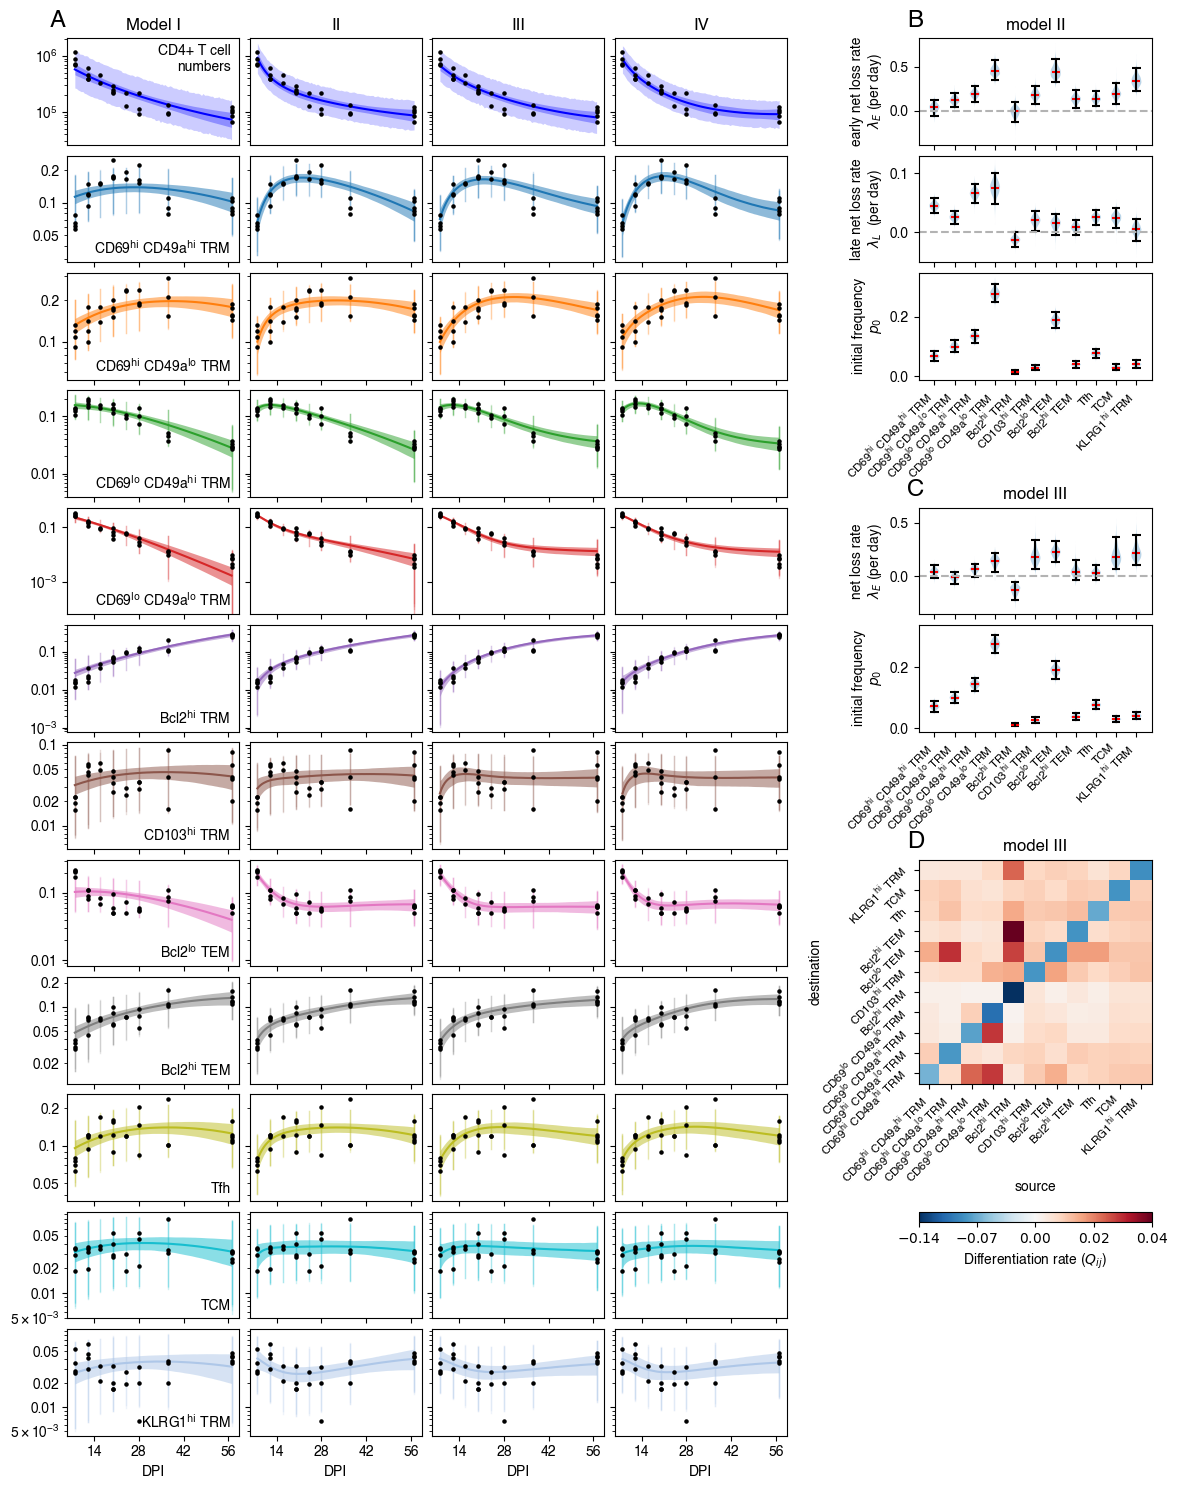

In [8]:
fig

In [9]:
#fig.savefig("../results/FigureSAFitCD4.pdf", bbox_inches='tight')